In [3]:
# %% Import modules
import torch as t
t.set_grad_enabled(False)
device = t.device('cpu') #'cuda' if torch.cuda.is_available() else 

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

from transformer_lens import HookedTransformer, FactoredMatrix
from load_data import get_prompts_t

In [4]:
#%% Setup model & load data
model = HookedTransformer.from_pretrained('gelu-4l')
model.cfg.use_attn_result = True
model.to(device)

prompts_t = get_prompts_t()

Loaded pretrained model gelu-4l into HookedTransformer
Moving model to device:  cpu
Loading 80 prompts from c4-tokenized-2b...


  0%|          | 0/80 [00:00<?, ?it/s]

Loading 20 prompts from code-tokenized...


  0%|          | 0/20 [00:00<?, ?it/s]

Get OV of layer 2 attn, perform SVD

In [5]:
cleaner_layer = 2
cleaner_head = 5

W_OV = FactoredMatrix(model.W_V[cleaner_layer, cleaner_head], model.W_O[cleaner_layer, cleaner_head])
W_OV.shape

torch.Size([512, 512])

SVD( W ) = U S V_T

first columns of U and V are corresponding to the first singular value

In [6]:
U, S, V = W_OV.svd()
print(f"{U.shape=}")
print(f"{S.shape=}")
print(f"{V.shape=}")

U.shape=torch.Size([512, 64])
S.shape=torch.Size([64])
V.shape=torch.Size([512, 64])


Is any reading direction (d_model) of U aligned with any writing direction (d_model) of V?
-> dot product of U and V along (d_model)

take abs, as extreme values matter!

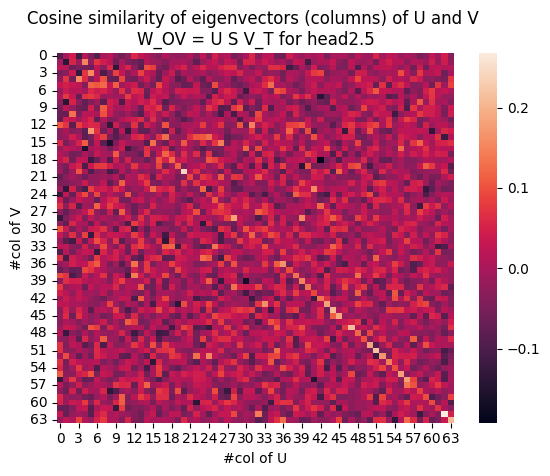

In [7]:
ax = sns.heatmap(V.T @ U, cbar="RdBu")
plt.title(f"Cosine similarity of eigenvectors (columns) of U and V \nW_OV = U S V_T for head{cleaner_layer}.{cleaner_head}")
plt.xlabel("#col of U")
plt.ylabel("#col of V");

In [27]:
def SVD_eigenvectors_heatmap(
    model: HookedTransformer,
    ax,
    cleaner_layer: int = 2,
    cleaner_head: int = 5,
) -> None:
    
    W_OV = FactoredMatrix(model.W_V[cleaner_layer, cleaner_head], model.W_O[cleaner_layer, cleaner_head])
    U, S, V = W_OV.svd()
    cos_sims = V.T @ U
    #cos_sims = t.abs(cos_sims)
    ax = sns.heatmap(cos_sims, cmap="RdBu", vmin=-0.7, vmax=0.7, ax=ax)
    ax.set_title(f"Cosine similarity of eigenvectors (columns) of U and V \nW_OV = U S V_T for head{cleaner_layer}.{cleaner_head}")
    ax.set_xlabel("#col of U")
    ax.set_ylabel("#col of V")
    return S

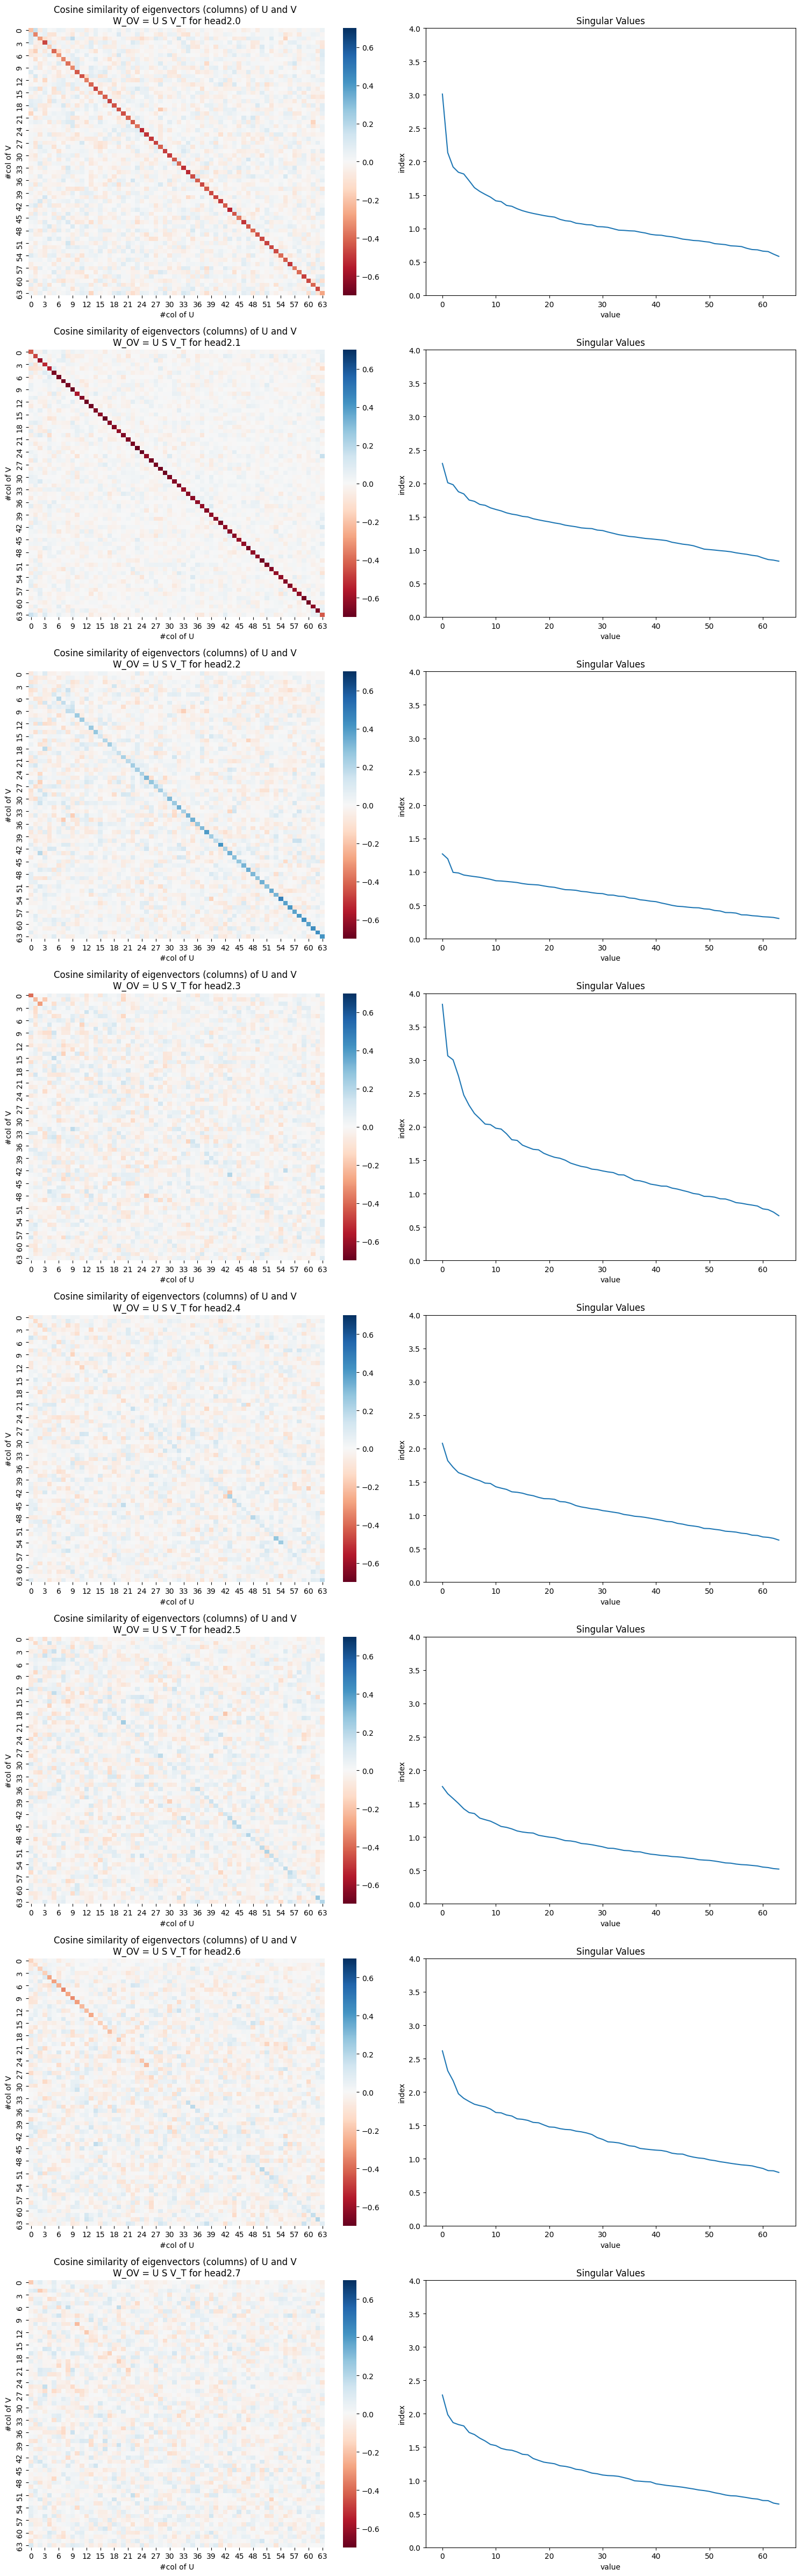

In [29]:
cleaner_layer = 2

fig, ax = plt.subplots(model.cfg.n_heads, 2, figsize=(15, 8*6))
for head_idx in range(model.cfg.n_heads):
    S = SVD_eigenvectors_heatmap(model, ax[head_idx, 0], cleaner_layer, head_idx)
    sns.lineplot(S, ax=ax[head_idx, 1], )
    ax[head_idx, 1].set_ylim(0,4)
    ax[head_idx, 1].set_xlabel("value")
    ax[head_idx, 1].set_ylabel("index")
    ax[head_idx, 1].set_title("Singular Values")
fig.tight_layout()